In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Load the data
df = pd.read_csv("../data/Copy of BrentOilPrices.csv", parse_dates=['Date'], index_col='Date')
df = df.sort_index()  # Ensure data is sorted by date
df = df.asfreq('D')   # Set frequency to daily to account for any missing days

# Forward fill missing prices
df['Price'].fillna(method='ffill', inplace=True)


In [5]:
df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-23,18.55
1987-05-24,18.55


In [6]:
df.tail()

,Price
Date,
2022-11-10,94.25
2022-11-11,96.37
2022-11-12,96.37
2022-11-13,96.37
2022-11-14,93.59


### Exploratory Data Analysis (EDA)

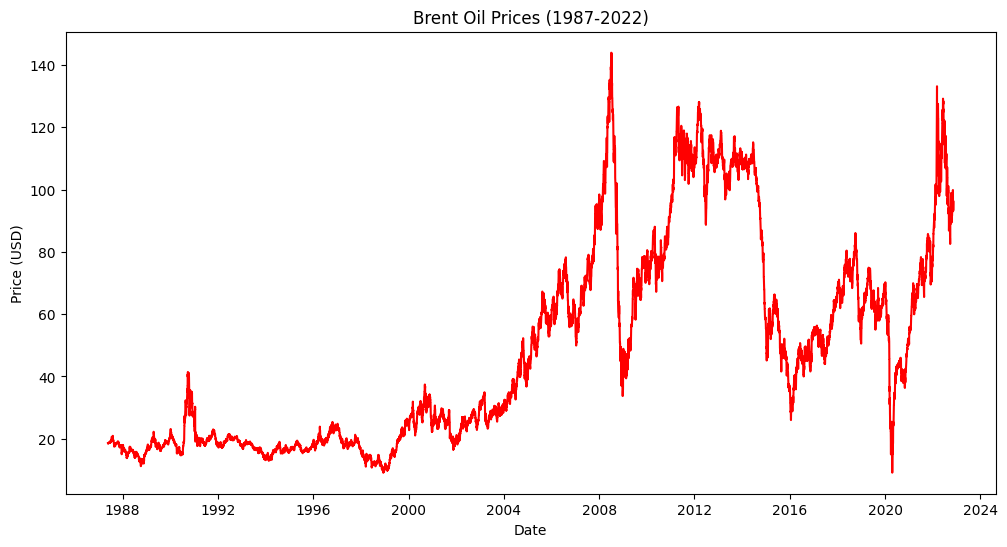

<Figure size 1200x600 with 0 Axes>

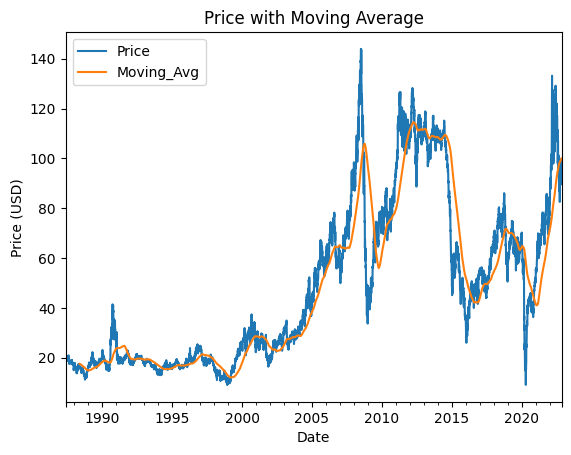

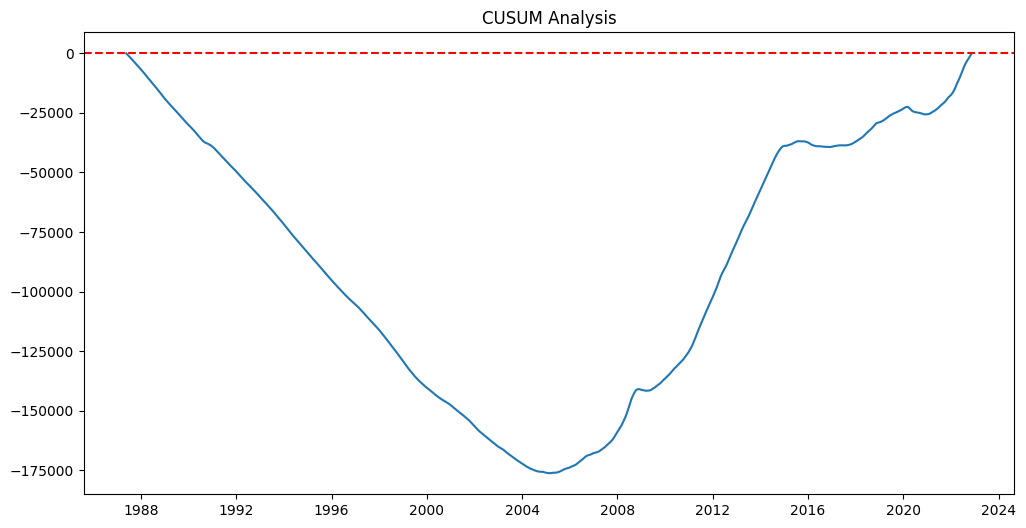

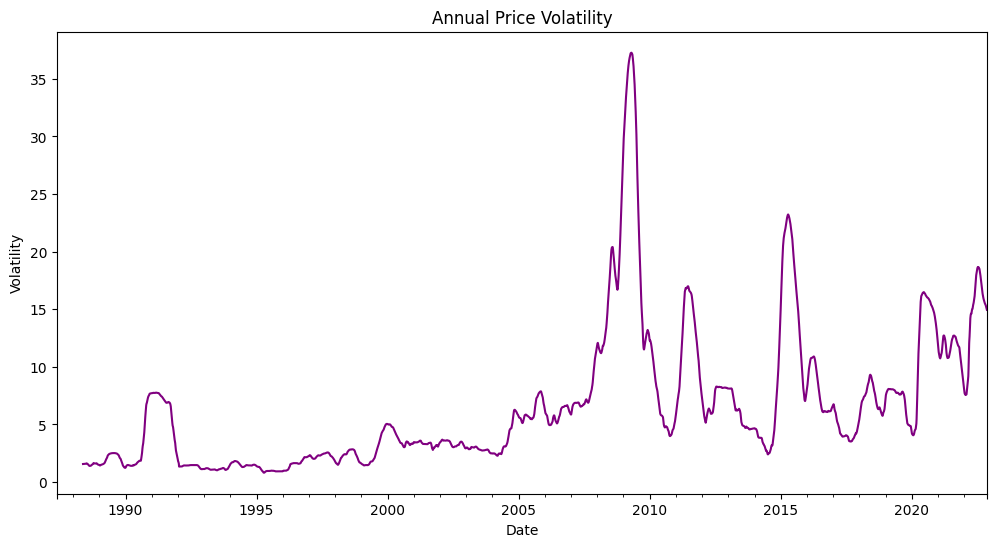

In [14]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], color='red')
plt.title('Brent Oil Prices (1987-2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()
mean_price = df["Price"].mean()
# Plot moving average and volatility
df['Moving_Avg'] = df['Price'].rolling(window=365).mean()  # Annual moving average
df['Volatility'] = df['Price'].rolling(window=365).std()   # Annual volatility


plt.figure(figsize=(12, 6))
df[['Price', 'Moving_Avg']].plot()
plt.title("Price with Moving Average")
plt.ylabel('Price (USD)')
plt.show()


cusum = np.cumsum(df["Price"] - mean_price)
plt.figure(figsize=(12,6))
plt.plot(df.index , cusum , label = "CUSUM")
plt.axhline(y=0,color='r',linestyle = "--")
plt.title("CUSUM Analysis")
plt.show()


plt.figure(figsize=(12, 6))
df['Volatility'].plot(color='purple')
plt.title("Annual Price Volatility")
plt.ylabel('Volatility')
plt.show()

### Change Point Analysis using PyMC3

In [5]:
# Convert date to a numerical index for modeling
time = np.arange(len(df))
price = df['Price'].values

with pm.Model() as model:
    # Priors for the change point and slopes before and after it
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(time))
    slope1 = pm.Normal('slope1', mu=0, sigma=1)
    slope2 = pm.Normal('slope2', mu=0, sigma=1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Define the trend with piecewise linear function
    trend = pm.Deterministic(
        'trend',
        intercept + slope1 * time * (time < tau) + slope2 * time * (time >= tau)
    )
    
    # Observed data likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    observed = pm.Normal('observed', mu=trend, sigma=sigma, observed=price)
    
    # Inference
    # trace = pm.sample(500, return_inferencedata=True,tune=500)
    trace = pm.sample(1, tune=1)
    trace = az.convert_to_inference_data(trace)

Only 1 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [sigma, intercept, slope2, slope1]


Sampling 2 chains for 1 tune and 1 draw iterations (2 + 2 draws total) took 36 seconds.


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\a\\1\\s\\numpy\\build\\openblas_info'

In [ ]:

# Plot the trend with change point
az.plot_trace(trace, var_names=['tau', 'slope1', 'slope2', 'intercept'])
plt.show()

In [ ]:
# Extract and plot the change point
tau_value = int(az.summary(trace)['mean']['tau'])
plt.figure(figsize=(12, 6))
plt.plot(time, price, label='Observed Price')
plt.plot(time, trace.posterior['trend'].mean(dim=['chain', 'draw']), color='blue', label='Estimated Trend')
plt.axvline(x=tau_value, color='black', linestyle='--', label='Change Point')
plt.legend()
plt.show()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12963 entries, 1987-05-20 to 2022-11-14
Freq: D
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price       12963 non-null  float64
 1   Moving_Avg  12599 non-null  float64
 2   Volatility  12599 non-null  float64
dtypes: float64(3)
memory usage: 405.1 KB


In [19]:
df.shape

(9011, 1)

In [8]:
df.isnull().sum()

Price    0
dtype: int64

In [9]:
df.duplicated().sum()

3996

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,9011.0,48.420782,32.86011,9.1,19.05,38.57,70.09,143.95


In [11]:
df.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


<Axes: xlabel='Price', ylabel='Count'>

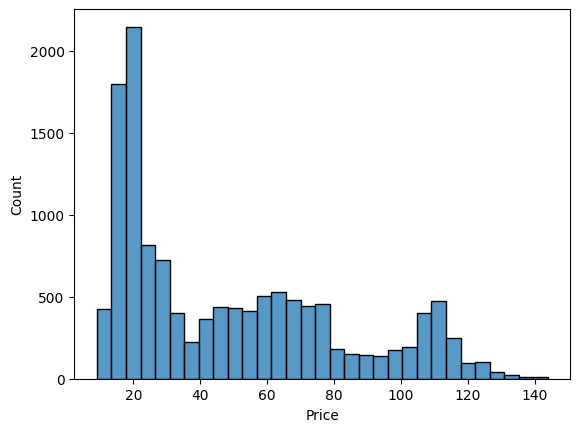

In [13]:
import seaborn as sns

sns.histplot(data=df, x=df["Price"])

In [21]:
import pymc3 as pm
import numpy as np
import arviz as az  # Optional: For visualization and summary of inference

# Define time and price arrays
time = np.arange(len(df))
price = df['Price'].values

with pm.Model() as model:
    # Priors for the change point and slopes before and after it
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(time))
    slope1 = pm.Normal('slope1', mu=0, sigma=1)
    slope2 = pm.Normal('slope2', mu=0, sigma=1)
    
    # Intercept prior
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Piecewise function for the price trend
    trend = pm.Deterministic(
        'trend', 
        intercept + slope1 * time * (time < tau) + slope2 * time * (time >= tau)
    )
    
    # Observed data likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    observed = pm.Normal('observed', mu=trend, sigma=sigma, observed=price)
    
    # Inference
    trace = pm.sample(1000, return_inferencedata=True)

# Visualize results using ArviZ
az.plot_trace(trace)

AttributeError: partially initialized module 'theano' has no attribute 'compile' (most likely due to a circular import)

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

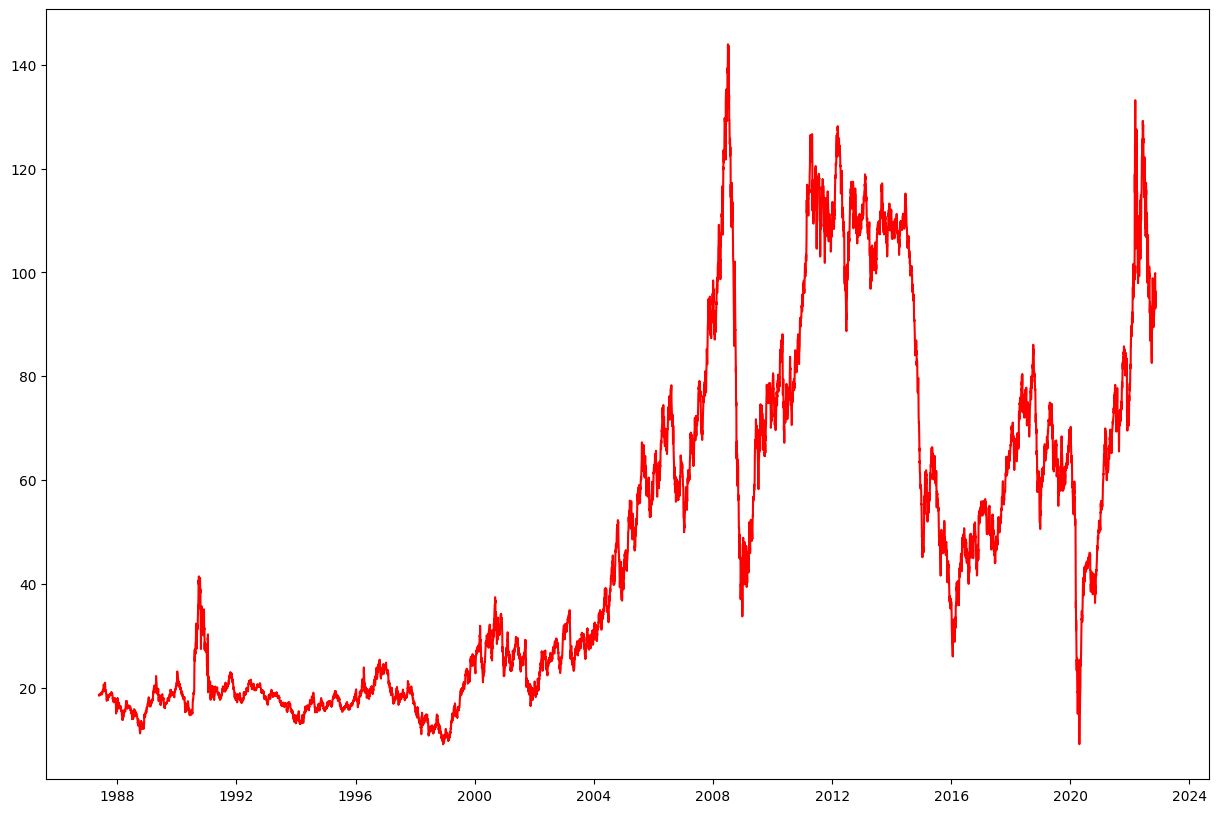

In [31]:
decomposition = seasonal_decompose(df["Price"],model="additive",period=1)

plt.figure(figsize=(15,10))
plt.plot(df['Price'],label = "Price" , color = "red")
plt.show()